In [27]:
import pandas as pd
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
from sklearn.metrics import recall_score, roc_auc_score, roc_curve, confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import cross_val_score
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import collections as c
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_columns', 2000)
pd.set_option('display.max_rows', 2000)

In [2]:
# model = pickle.load(open('logistic_regression_completion_first_half.p', 'rb')) # load the model

In [3]:
model = LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=10, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='newton-cg',
          tol=1e-09, verbose=0, warm_start='False')

In [4]:
def scale_subset(df, columns):
    '''
    Use sklearn StandardScalar to scale only numeric columns.

    Parameters:
    ----------
    input {dataframe, list}: dataframe containing mixed feature variable types, list of names of numeric feature columns
    output: {dataframe}: dataframe with numeric features scaled and categorical features unchanged

    '''
    scalar = StandardScaler()
    numeric = df[columns]
    categorical = df.drop(columns, axis = 1)
    scalar.fit(numeric)
    num_scaled = pd.DataFrame(scalar.transform(numeric))
    num_scaled.rename(columns = dict(zip(num_scaled.columns, numeric_cols)), inplace = True)
    return pd.concat([num_scaled, categorical], axis = 1)


In [5]:
X_train = pd.read_csv('../data/processed/first_half/X_train.csv')
y_train = pd.read_csv('../data/processed/first_half/y_train.csv')
y_train = y_train['module_not_completed']
X_test = pd.read_csv('../data/processed/first_half/X_test.csv')

y_test = pd.read_csv('../data/processed/first_half/y_test.csv')
y_test = y_test['module_not_completed']

numeric_cols = ['num_of_prev_attempts', 'studied_credits', 'module_presentation_length', 'sum_click_dataplus', 'sum_click_dualpane', 'sum_click_externalquiz', 'sum_click_forumng','sum_click_glossary', 'sum_click_homepage', 'sum_click_htmlactivity', 'sum_click_oucollaborate', 'sum_click_oucontent', 'sum_click_ouelluminate', 'sum_click_ouwiki', 'sum_click_page', 'sum_click_questionnaire', 'sum_click_quiz', 'sum_click_repeatactivity', 'sum_click_resource', 'sum_click_sharedsubpage', 'sum_click_subpage', 'sum_click_url', 'sum_days_vle_accessed', 'max_clicks_one_day', 'first_date_vle_accessed', 'avg_score', 'avg_days_sub_early', 'days_early_first_assessment', 'score_first_assessment']

# fill and scale
X_train.fillna(value = 0, inplace = True)
X_train = scale_subset(X_train, numeric_cols)
X_test.fillna(value = 0, inplace = True)
X_test = scale_subset(X_test, numeric_cols)



/Users/jeremymiller/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/jeremymiller/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  from ipykernel import kernelapp as app
/Users/jeremymiller/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/jeremymiller/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  from ipykernel import kernelapp as app


In [6]:
# # drop features with collinearity (need VIF)
# # X_train.drop(withdrawls, inplace=True)
# X_train.drop(['days_early_first_assessment', 'pct_days_vle_accessed', 'score_first_assessment'], axis=1, inplace=True)
# X_test.drop(['days_early_first_assessment', 'pct_days_vle_accessed', 'score_first_assessment'], axis=1, inplace=True)
# # y_train.drop(withdrawls, inplace=True)

In [7]:
model.fit(X_train, y_train)

/Users/jeremymiller/anaconda3/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=10, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='newton-cg',
          tol=1e-09, verbose=0, warm_start='False')

In [8]:
predictions = model.predict(X_test)

In [9]:
recall = recall_score(y_test, predictions, average = 'micro')
recall

0.8149869840089252

In [10]:
roc_auc = roc_auc_score(y_test, predictions)
roc_auc

0.8165167795694469

In [11]:
probas = model.predict_proba(X_test)[:, :1]
tprs, fprs, thresh = roc_curve(y_test, probas)

In [12]:
probas

array([[0.59531989],
       [0.42860753],
       [0.96460606],
       ...,
       [0.00247937],
       [0.72638771],
       [0.59342222]])

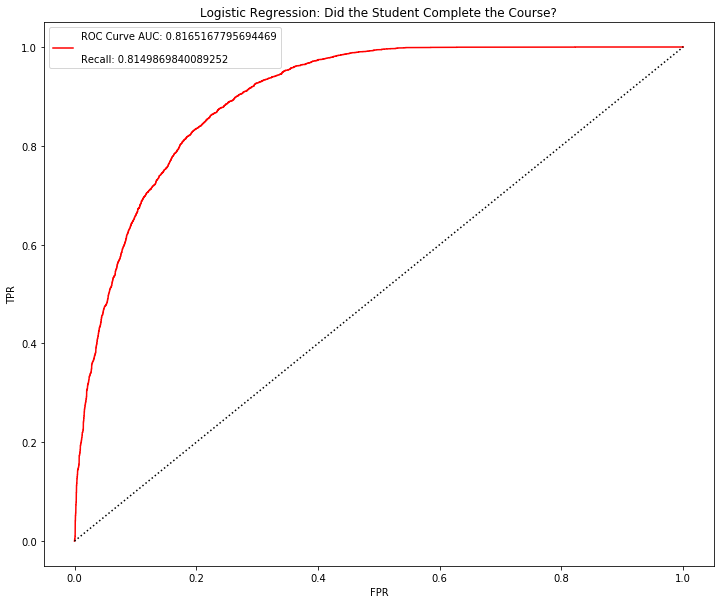

In [13]:
plt.figure(figsize=(12,10))
plt.plot(fprs, tprs, 
    label='ROC Curve AUC: {}\n\nRecall: {}'.format(roc_auc, recall),
    color='red')
plt.plot([0,1],[0,1], 'k:')
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("Logistic Regression: Did the Student Complete the Course?")
plt.show()

In [14]:
cross_val_score(model, X_train, y_train, scoring='roc_auc')

/Users/jeremymiller/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/jeremymiller/anaconda3/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/Users/jeremymiller/anaconda3/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/Users/jeremymiller/anaconda3/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


array([0.89777367, 0.90070827, 0.89406059])

In [15]:
# pd.DataFrame(data={'fprs': fprs, 'tprs': tprs, 'Thresholds': thresh})

# Which features are most important?

In [37]:
vif = []
for v in range(len(X_train.columns)):
    vif.append(variance_inflation_factor(X_train.values, v))
features = list(X_test.columns)

In [38]:
vif_dict = c.OrderedDict((zip(vif, features)))

In [39]:
sorted(vif_dict.items(), reverse=True)

[(34.82408402588052, 'code_presentation_2014J'),
 (27.902556097941535, 'module_presentation_length'),
 (17.71032093366156, 'sum_days_vle_accessed'),
 (12.29325003243407, 'avg_score'),
 (12.129102421725705, 'code_module_BBB'),
 (11.26607390128323, 'score_first_assessment'),
 (10.74221505000013, 'code_module_DDD'),
 (10.185010067236496, 'code_module_FFF'),
 (7.1850167216113165, 'days_early_first_assessment'),
 (6.982777427209344, 'avg_days_sub_early'),
 (6.25857902466213, 'sum_click_subpage'),
 (5.987724047700888, 'sum_click_homepage'),
 (5.985776569586089, 'code_module_CCC'),
 (4.404699645329355, 'code_module_GGG'),
 (4.251087737583301, 'code_module_EEE'),
 (4.017647137076836, 'sum_click_oucontent'),
 (3.302057016316897, 'sum_click_forumng'),
 (2.484169459349674, 'sum_click_questionnaire'),
 (2.3875743194882575, 'sum_click_page'),
 (2.2302142456326295, 'sum_click_url'),
 (2.1887320831463035, 'sum_click_quiz'),
 (2.0796027088448876, 'max_clicks_one_day'),
 (1.8609248467923418, 'sum_click

In [16]:
abs_coef = list(np.abs(model.coef_.ravel()))
features = list(X_test.columns)

In [17]:
coef_dict = c.OrderedDict((zip(abs_coef, features)))

In [18]:
sorted(coef_dict.items(), reverse=True)

[(2.366241356565626, 'avg_score'),
 (2.334807019985692, 'sum_days_vle_accessed'),
 (1.2005239375092331, 'code_module_CCC'),
 (1.1428750450131573, 'code_module_FFF'),
 (1.0650867222720795, 'code_module_GGG'),
 (0.9286502548321103, 'code_module_EEE'),
 (0.8706400308088543, 'code_module_DDD'),
 (0.7406903063138868, 'imd_band_nan'),
 (0.6612979880616006, 'code_presentation_2014J'),
 (0.6403845545350861, 'code_presentation_2013J'),
 (0.6016121111763946, 'score_first_assessment'),
 (0.5887621767177402, 'highest_education_No Formal quals'),
 (0.49288373039077854, 'highest_education_Lower Than A Level'),
 (0.4715941509727261, 'imd_band_90-100%'),
 (0.4545771890570024, 'sum_click_subpage'),
 (0.4541781257953193, 'sum_click_forumng'),
 (0.37545321092009554, 'imd_band_60-70%'),
 (0.3565359874290081, 'imd_band_80-90%'),
 (0.3080096015100905, 'imd_band_30-40%'),
 (0.30780494490851107, 'sum_click_homepage'),
 (0.30697217491095274, 'imd_band_50-60%'),
 (0.2831136936917378, 'region_Wales'),
 (0.278375

In [19]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

       False       0.78      0.84      0.81      5062
        True       0.85      0.79      0.82      5694

   micro avg       0.81      0.81      0.81     10756
   macro avg       0.82      0.82      0.81     10756
weighted avg       0.82      0.81      0.82     10756



In [20]:
accuracy_score(y_test, predictions)

0.8149869840089252

In [21]:
print(confusion_matrix(y_test, predictions))

[[4265  797]
 [1193 4501]]


In [22]:
# pickle.dump(model, open('logistic_regression_completion.p', 'wb')) # pickle the model

Correlated predictor variables

In [23]:
cor = X_train.corr().abs()

In [24]:
s = cor.unstack()

In [25]:
so = s.sort_values(kind="quicksort", ascending=False)

In [26]:
so[::2]

disability_Y                                   disability_Y                                     1.000000
code_presentation_2013J                        code_presentation_2013J                          1.000000
code_presentation_2014J                        code_presentation_2014J                          1.000000
region_East Midlands Region                    region_East Midlands Region                      1.000000
region_London Region                           region_London Region                             1.000000
region_North Western Region                    region_North Western Region                      1.000000
region_South East Region                       region_South East Region                         1.000000
region_South West Region                       region_South West Region                         1.000000
region_Yorkshire Region                        region_Yorkshire Region                          1.000000
highest_education_HE Qualification             highest_